# Fit linear readout predicting female behav vars from simulated neural population activity

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model
import sys

from disp import set_plot
from my_torch import skl_fit_ridge

cc = np.concatenate


TARG_BHV = 'MTN'
TWDWS = [.03, 1, 60]
TARGS = [f'{TARG_BHV}_MN_{twdw}' for twdw in TWDWS]

PFX_BHV = f'data/simple/behav_xtd/behav_xtd'

NNRN = 224
NRL_MDLS = [
    'ma',  # mult-adapt neural model
    
    'lnma',  # lin-nonlin neural model w MA-derived filters
    'lnr',  # linear-nonlinear model (fit w ridge regr)
    
    'linma',  # linear neural model w MA-derived filters
    'linr',  # linear neural model (fit w ridge regr)
    
    'ma_ind_ta',
    'ma_sia',
    'masrb',
    'masrb_pq',
    
#     'lnr_relu',  
#     'lnr_relu_flex',
    'lnma_tweaked',  # lin-nonlin neural model w double-exp filter optimized from MA fit
    'lnma_tweaked_4',  # lin-nonlin neural model w double-exp filter optimized from MA fit
    
#     'lin',  # linear neural model
#     'ln',  # linear-nonlinear model
]

PTRAIN = .8
NSPLIT = 30

ALPHA = 10

NSPLIT_SAVE_Y_HAT = 5

MASK_PFX = 'data/simple/masks/mask'

if MASK_PFX:
    FSAVE_SFX = f'{TARG_BHV.lower()}_ridge_alpha_{ALPHA}_masked'
else:
    FSAVE_SFX = f'{TARG_BHV.lower()}_ridge_alpha_{ALPHA}'

In [2]:
# SPECIFY STRAINS USED
STRAINS = ['NM91', 'ZH23']
STRAIN_KEY = '_'.join(STRAINS).lower()

FSTRAIN = 'data/simple/strains.csv'
MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = len(ISTRAIN)
NTRAIN = int(round(PTRAIN*NTR))

In [ ]:
for nrl_mdl in NRL_MDLS:
    print(f'\nMODEL: {nrl_mdl}')
    pfx_nrl = f'data/simple/mlv/neur_basic/baker_{nrl_mdl}/mlv_baker_{nrl_mdl}'

    r_cols_use = [f'R_{inrn}' for inrn in range(NNRN)]

    fsave = f'data/simple/mlv/neur_basic/baker_{nrl_mdl}_{STRAIN_KEY}_{FSAVE_SFX}.npy'

    # fit regression models
    rslts = skl_fit_ridge(
        pfxs=[pfx_nrl, PFX_BHV],
        cols_x=r_cols_use,
        targs=TARGS,
        itr_all=ISTRAIN, 
        ntrain=NTRAIN,
        nsplit=NSPLIT,
        mask_pfx=MASK_PFX,
        return_y=np.arange(NSPLIT_SAVE_Y_HAT),
        alpha=ALPHA)

    # save r2, weights, and example predictions
    save_data = {
        'r2_train': {targ: np.array([rslt.r2_train[targ] for rslt in rslts]) for targ in TARGS},
        'r2_test': {targ: np.array([rslt.r2_test[targ] for rslt in rslts]) for targ in TARGS},
        
        'w': {targ: np.array([rslt.w[targ] for rslt in rslts]) for targ in TARGS},
        'bias': {targ: np.array([rslt.bias[targ] for rslt in rslts]) for targ in TARGS},
        
        'ys_train': {targ: [rslt.ys_train[targ] for rslt in rslts if rslt.ys_train] for targ in TARGS},
        'ys_test': {targ: [rslt.ys_test[targ] for rslt in rslts if rslt.ys_train] for targ in TARGS},
        
        'y_hats_train': {targ: [rslt.y_hats_train[targ] for rslt in rslts if rslt.ys_train] for targ in TARGS},
        'y_hats_test': {targ: [rslt.y_hats_test[targ] for rslt in rslts if rslt.ys_train] for targ in TARGS},
        
        'targs': TARGS,
        'alpha': ALPHA,
        
        'ntr': NTR,
        'ntrain': NTRAIN,
        'nsplit': NSPLIT,
        
        'nr': len(r_cols_use)
    }

    np.save(fsave, np.array([save_data]))

ma
0.13423141682186762
0.2267878666210312
0.26587789061882455

lnma
0.10006630663834055
0.14807999129768917
0.1132675047094424

lnr
0.07152077365848128
0.08832951583729304
0.06116546027219115

linma
0.08194157878728041
0.11080408341894363
0.07605540900367296

linr
0.05329733529492502
0.04956670247190862
0.01544541720051392

ma_ind_ta
0.13975940653152705
0.2387038391171375
0.29136745208279163

ma_sia
0.1230402445290107
0.20043024480567997
0.21844197266149484

masrb
0.13529817602688451
0.22976986941497496
0.2735905116522925

masrb_pq
0.13376125228712737
0.22620612235760001
0.2630004137954567

lnma_tweaked
0.08141226723637637
0.13961570303460952
0.10933067958883898

lnma_tweaked_4
0.08310141056300825
0.11202081350829023
0.08343202719922246



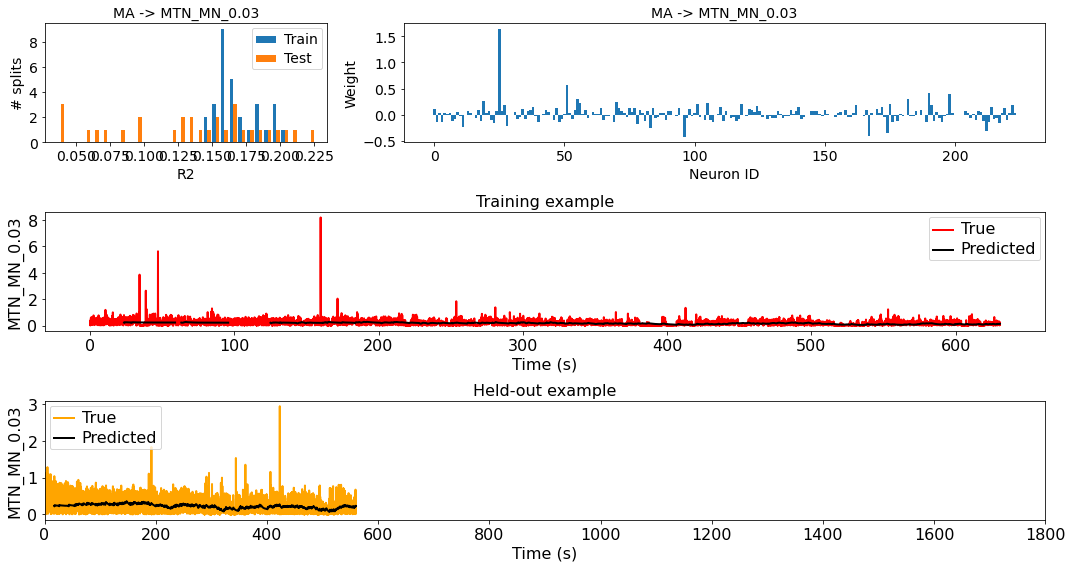

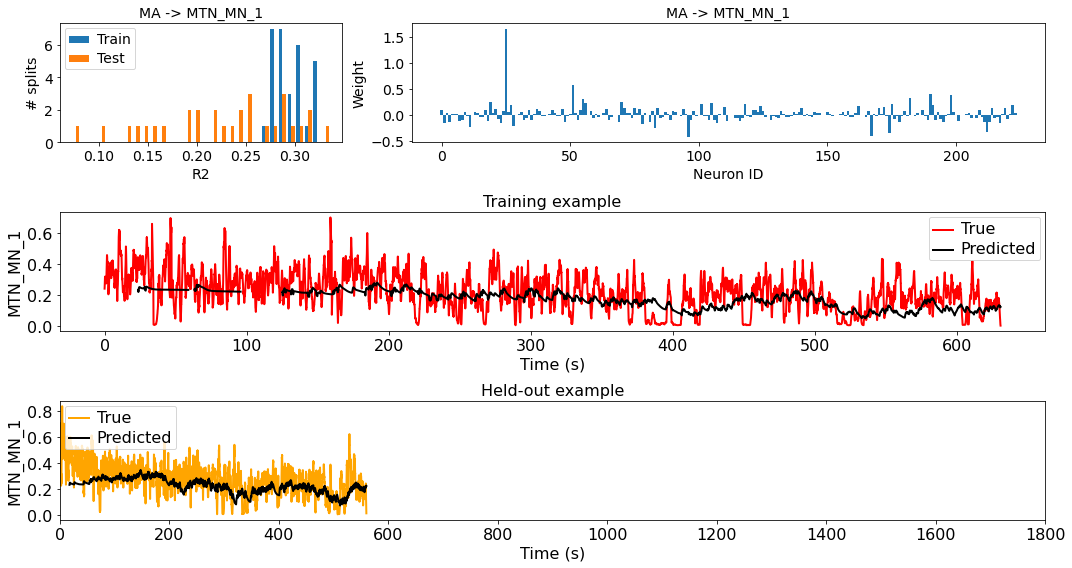

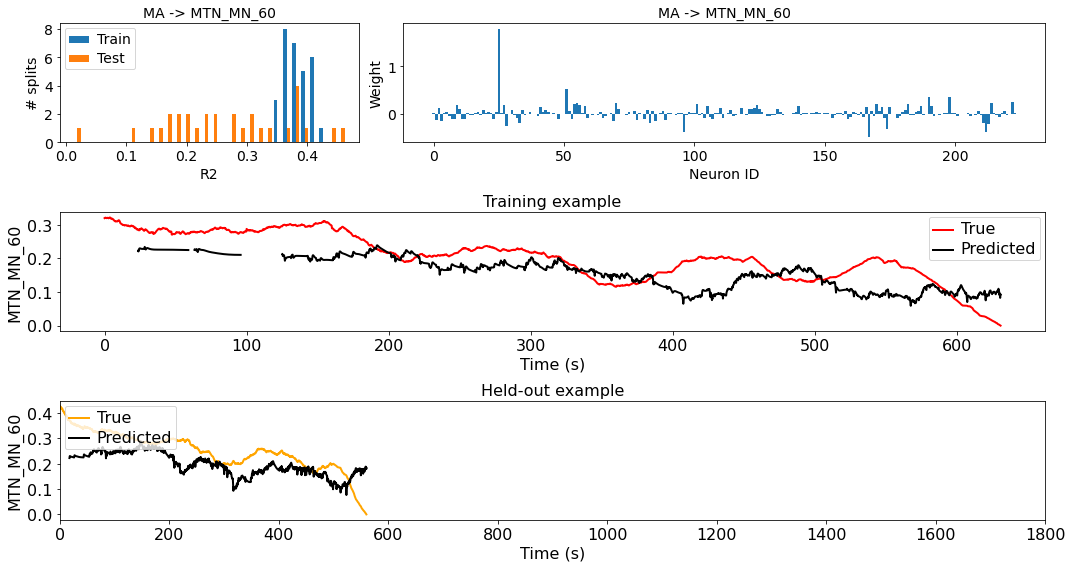

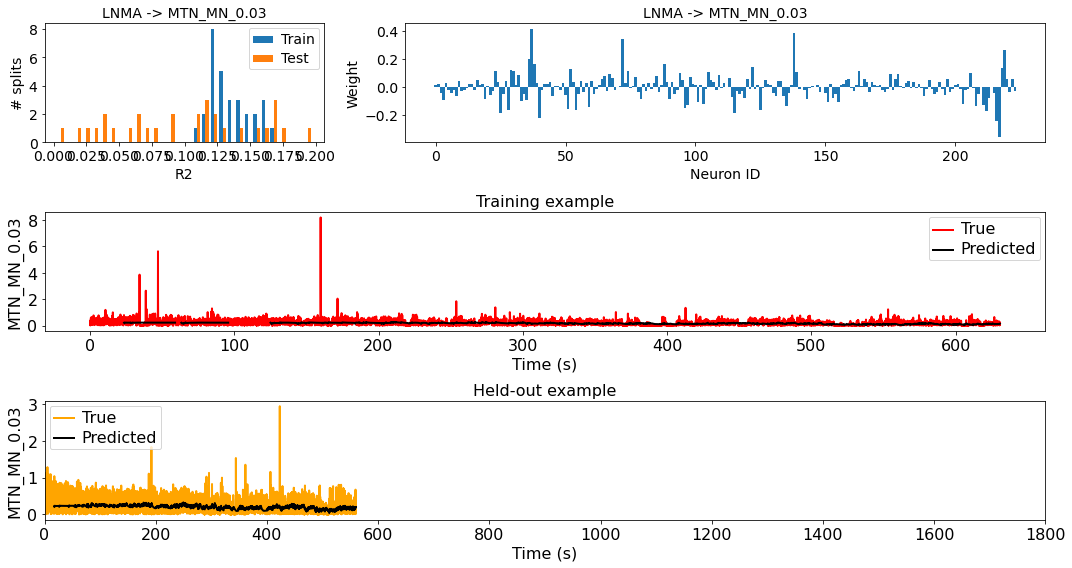

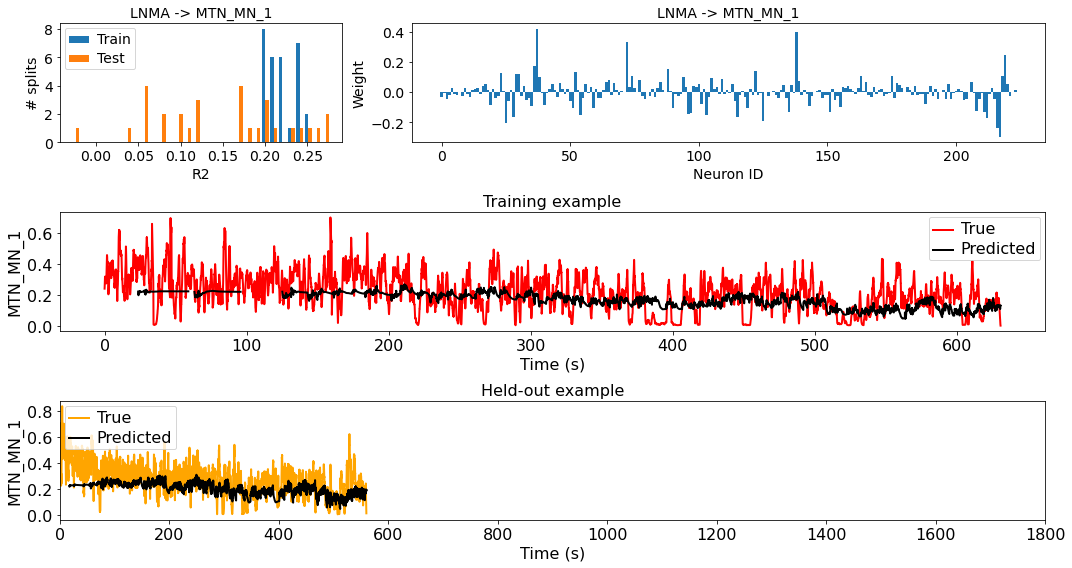

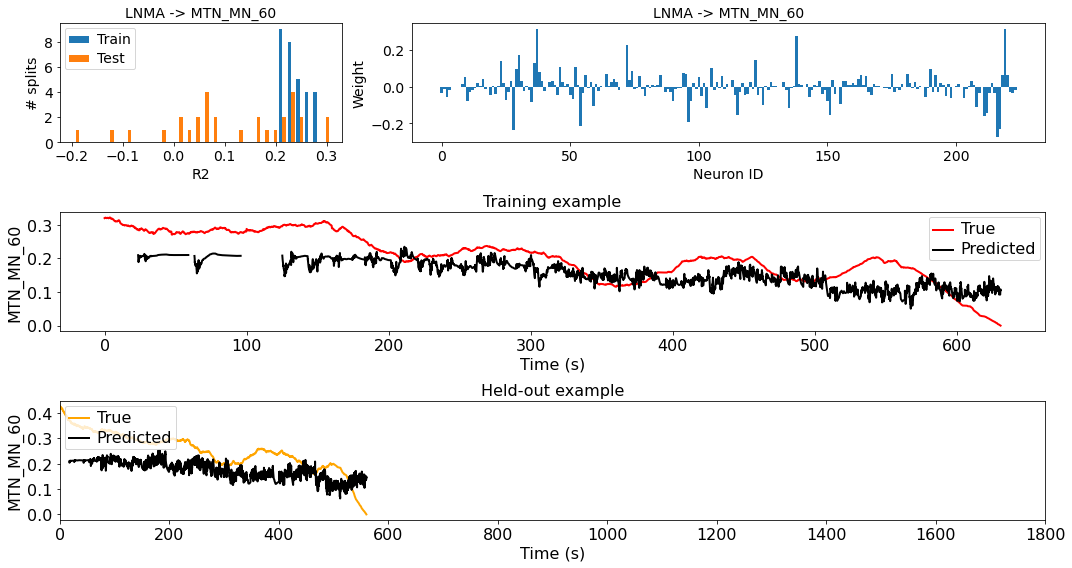

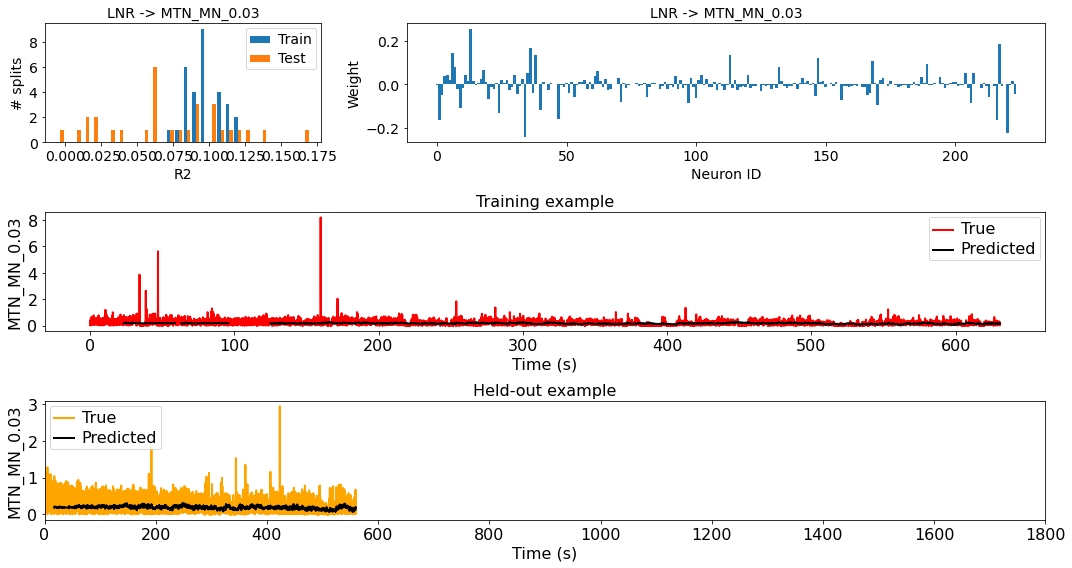

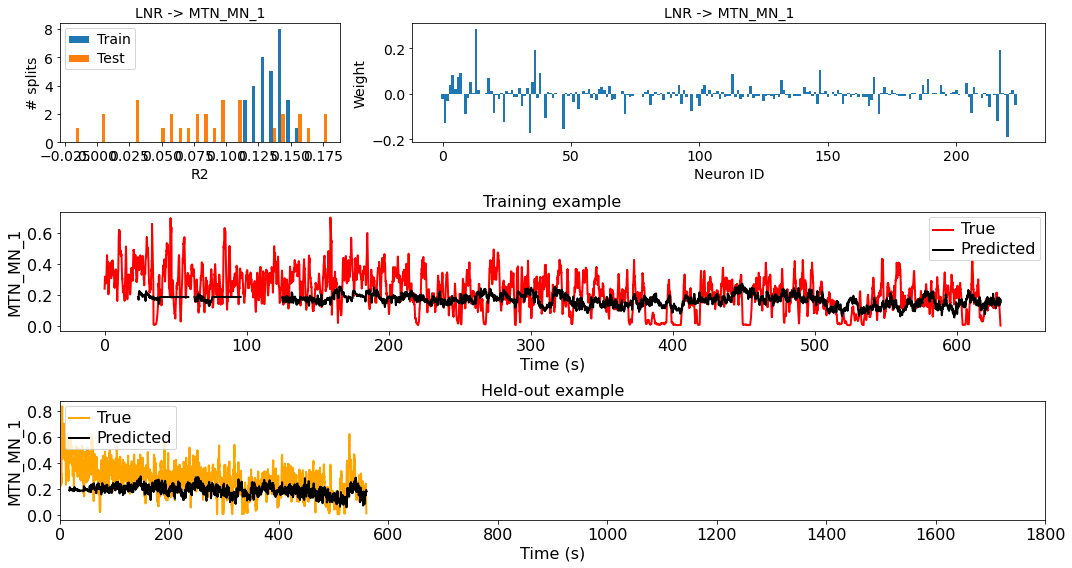

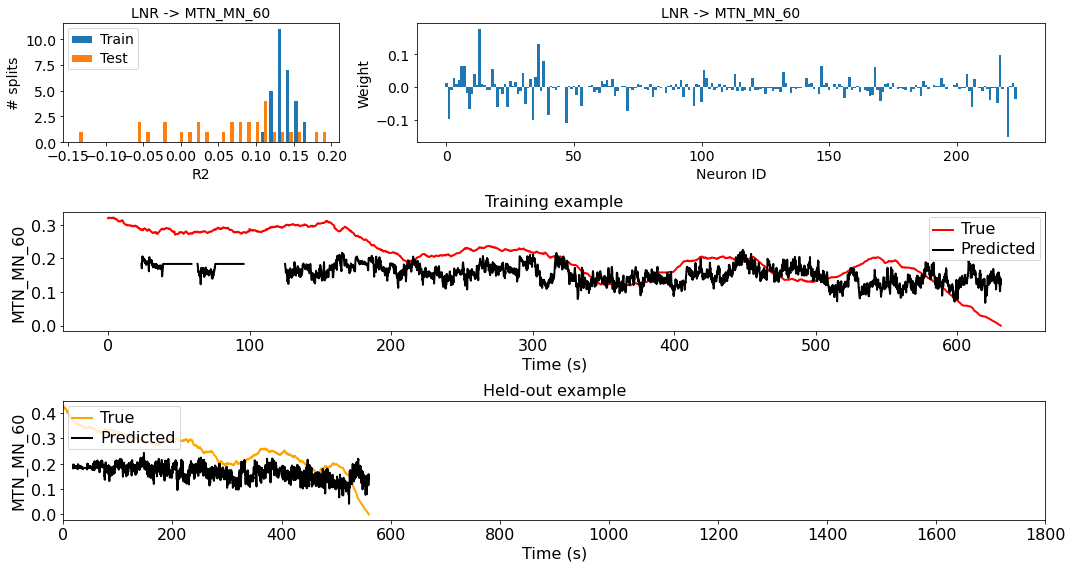

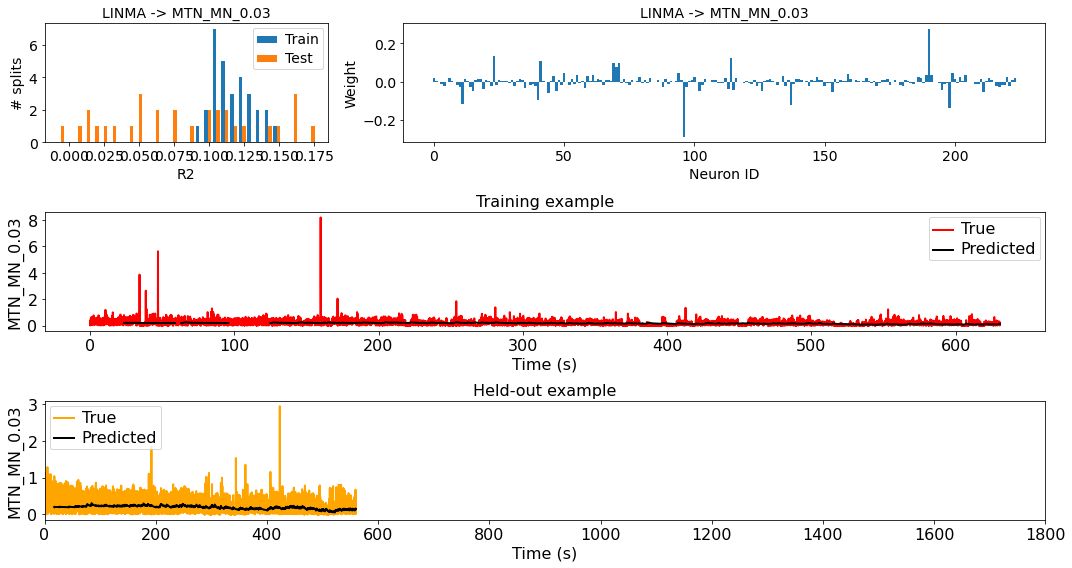

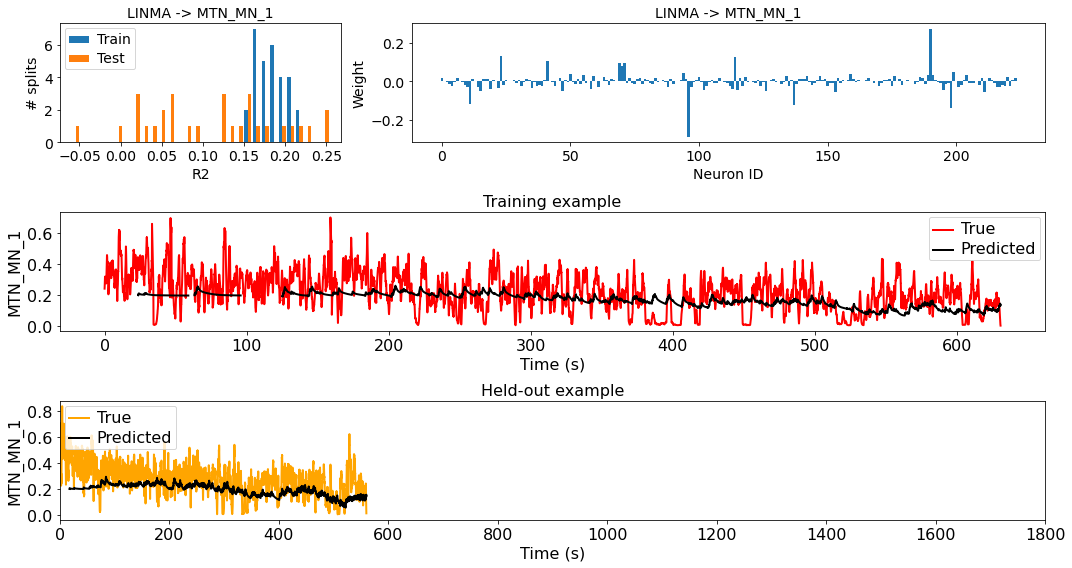

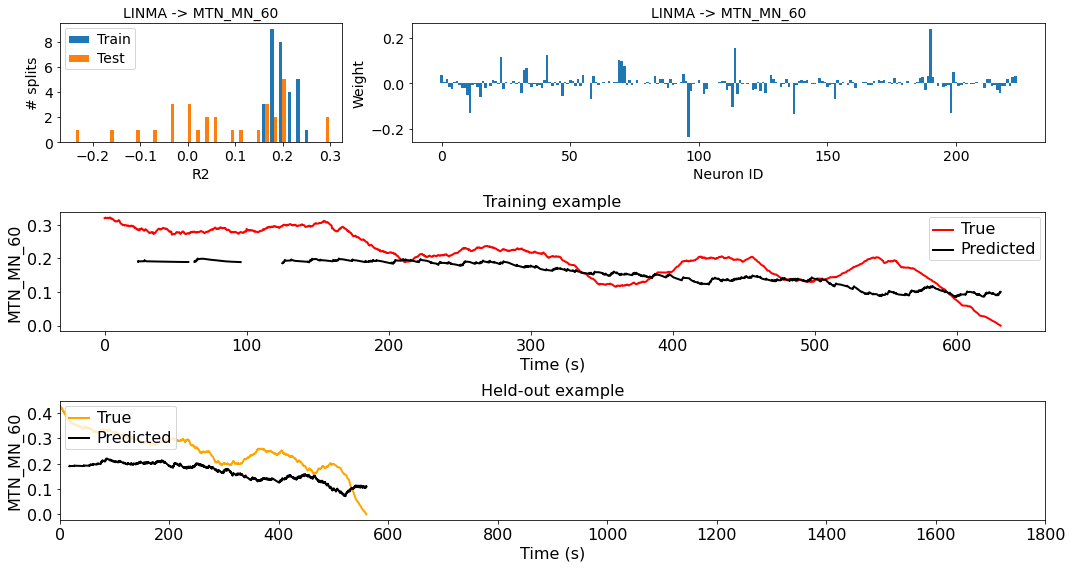

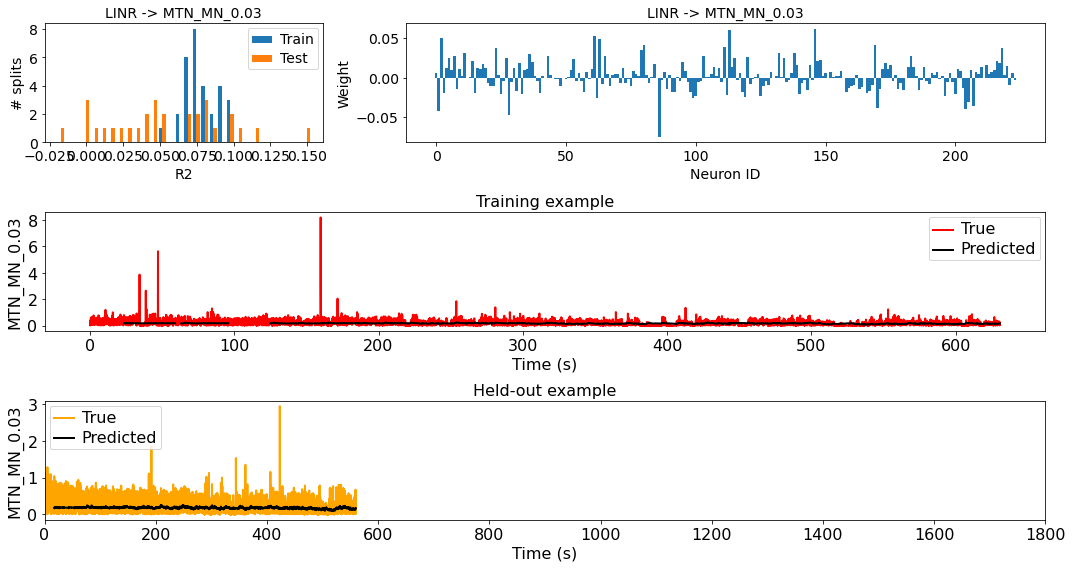

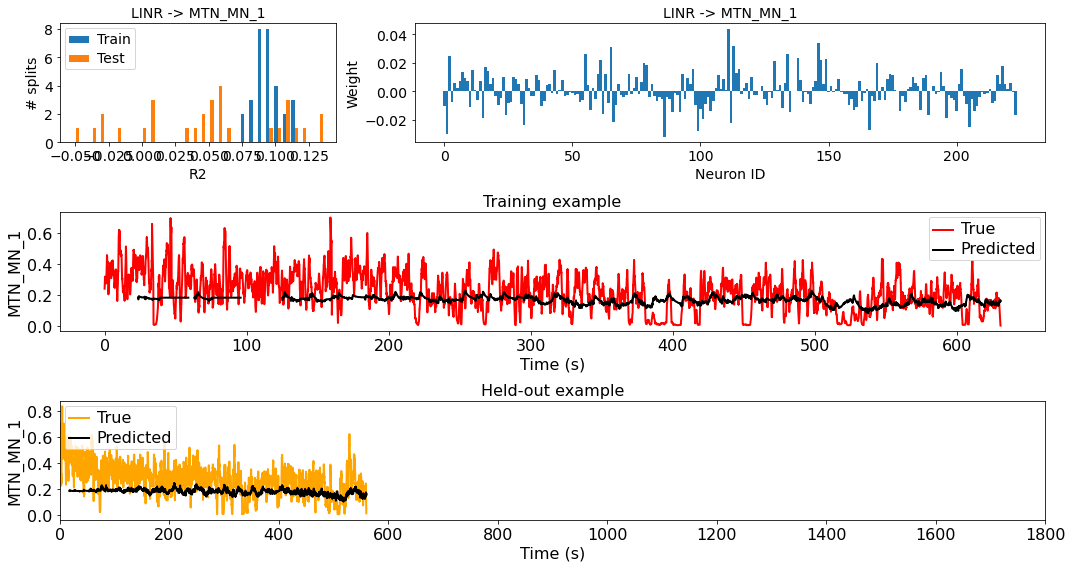

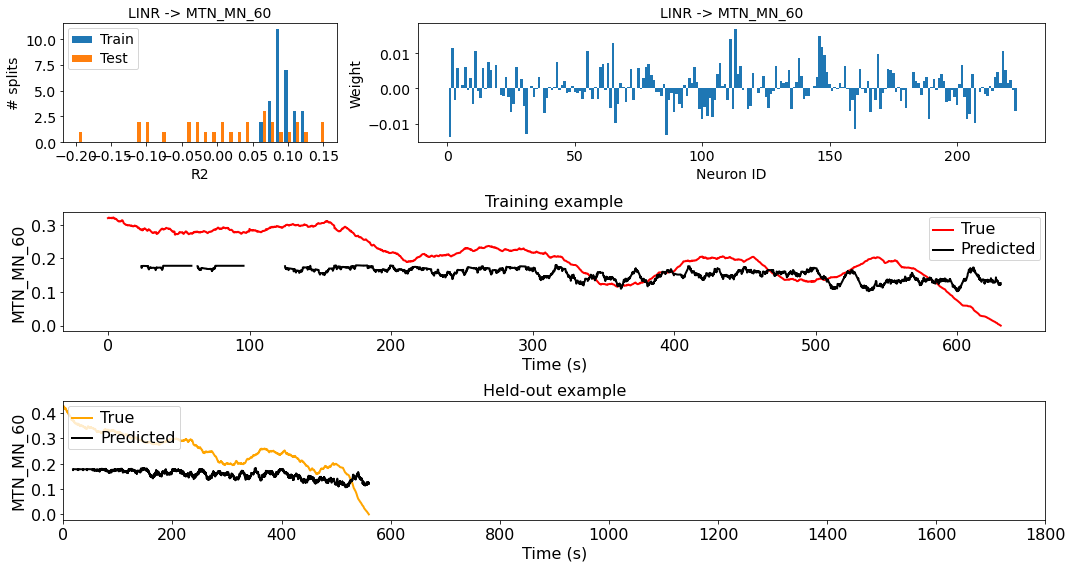

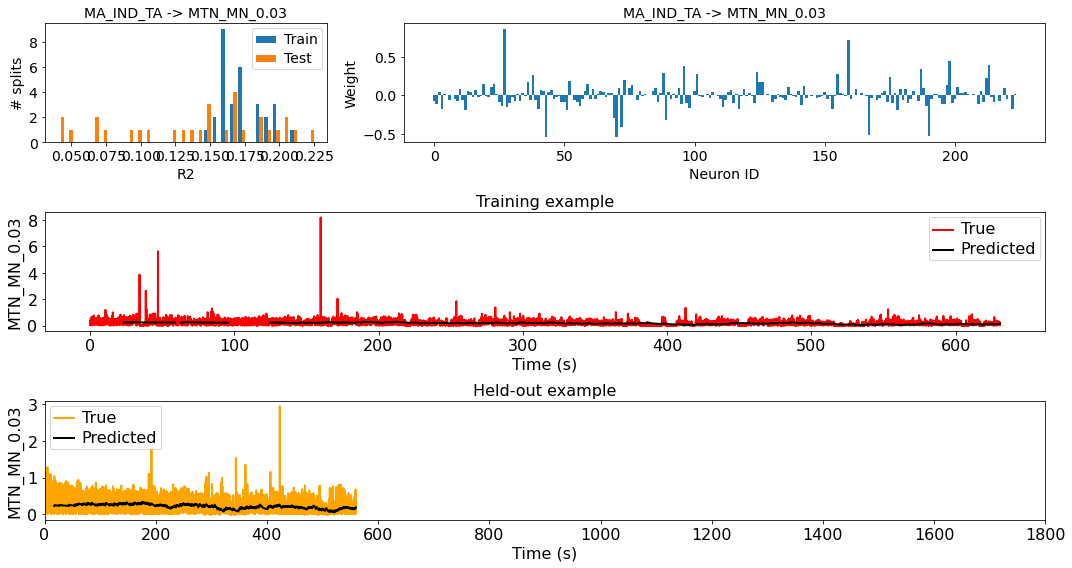

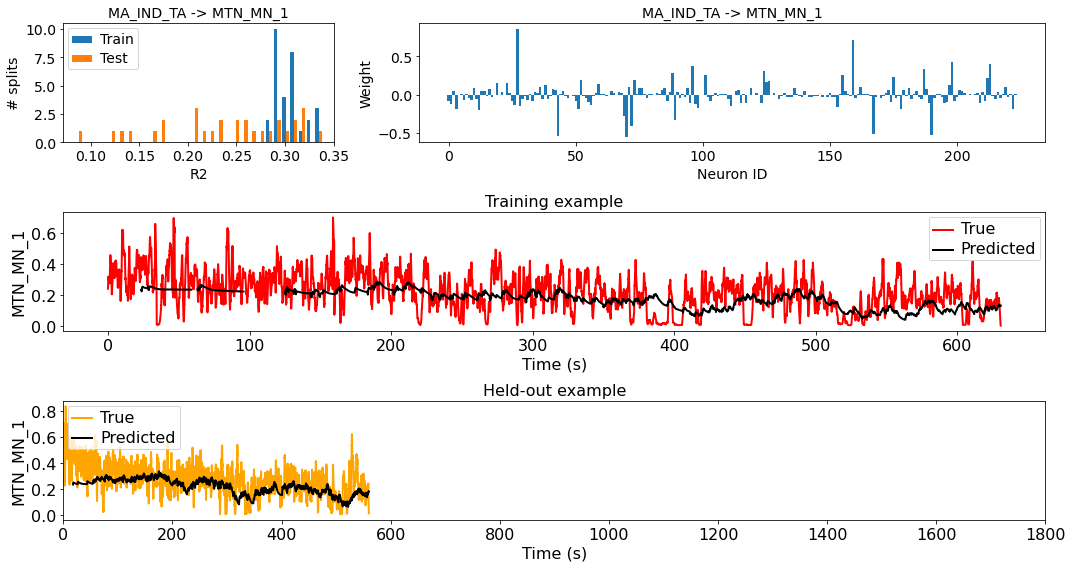

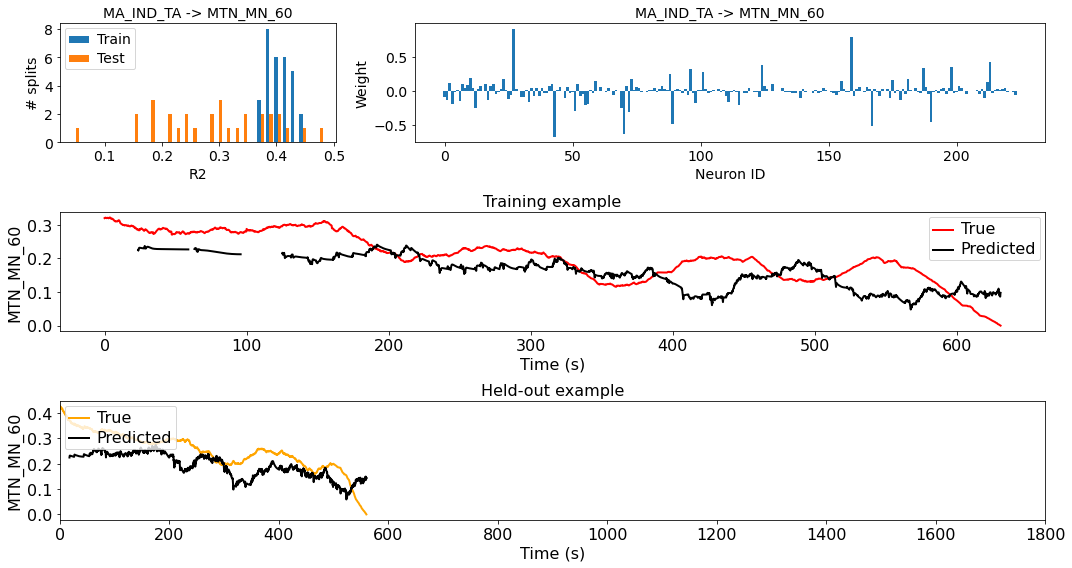

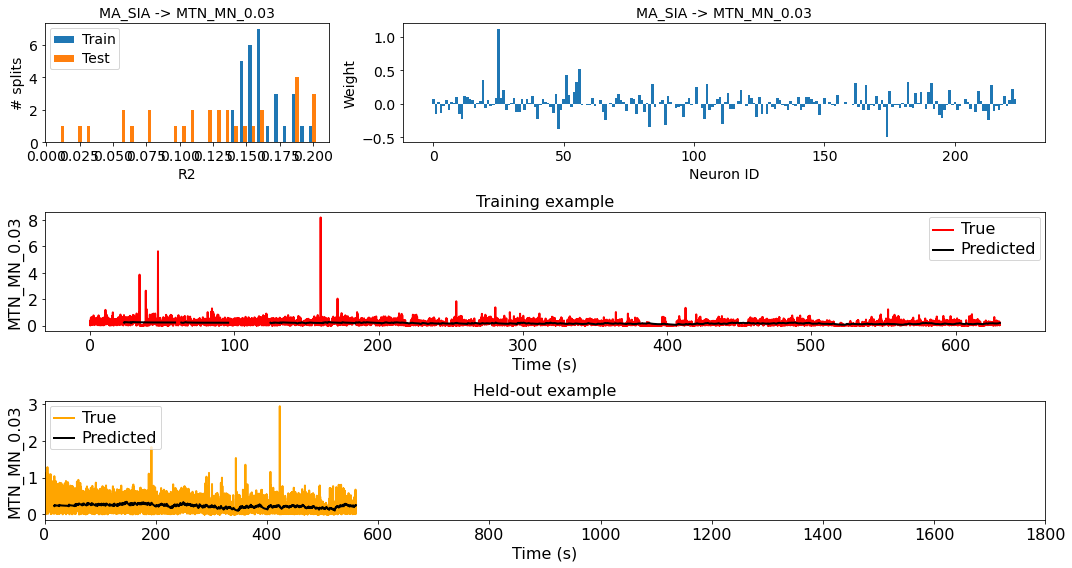

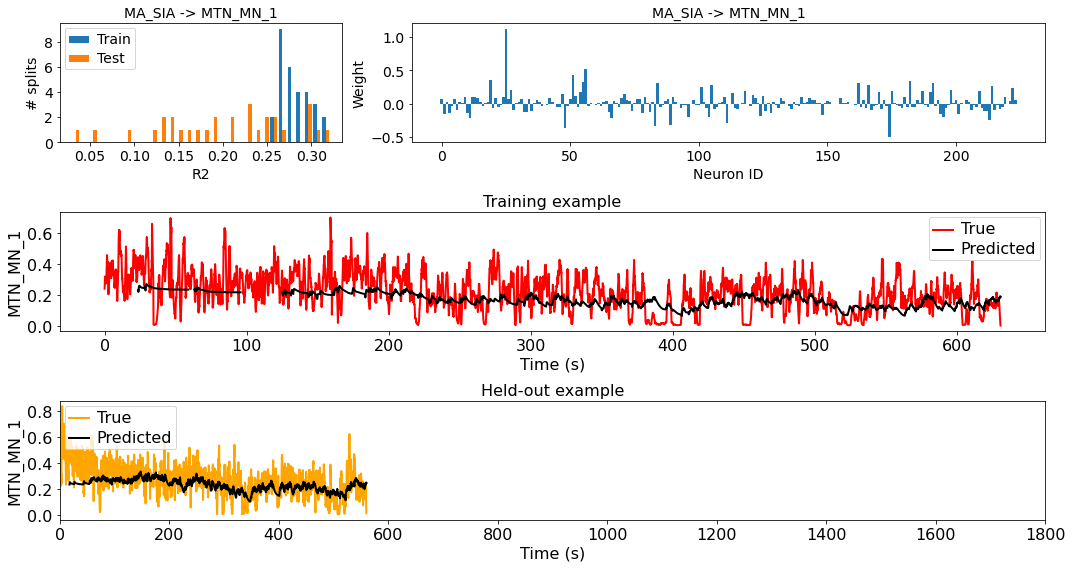

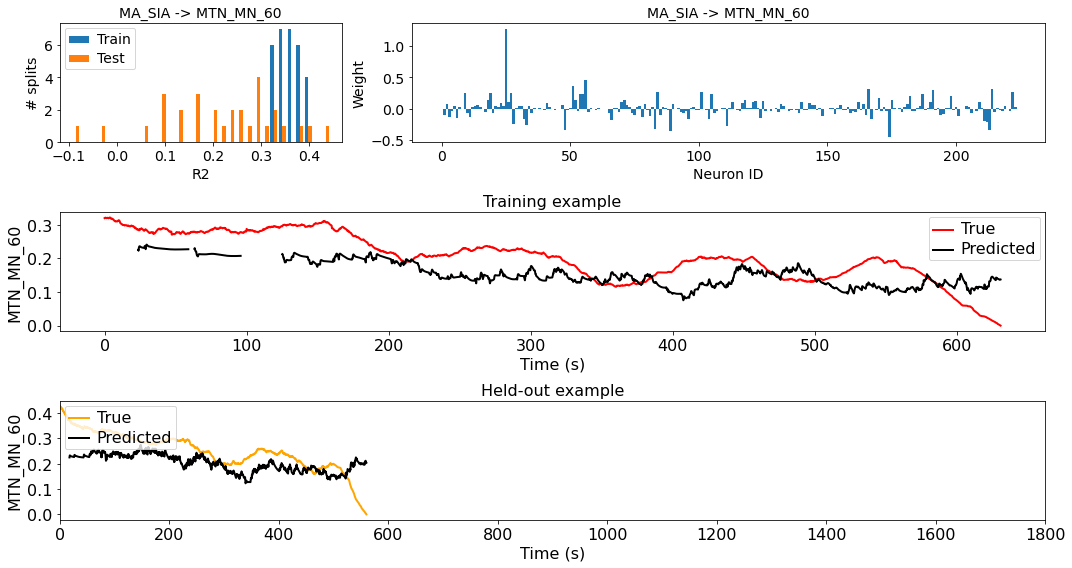

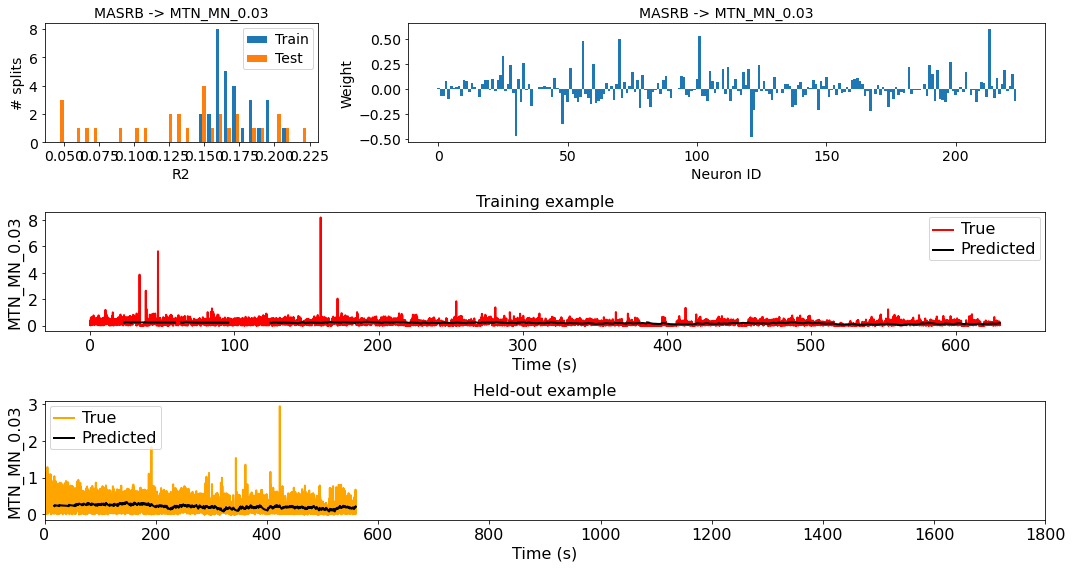

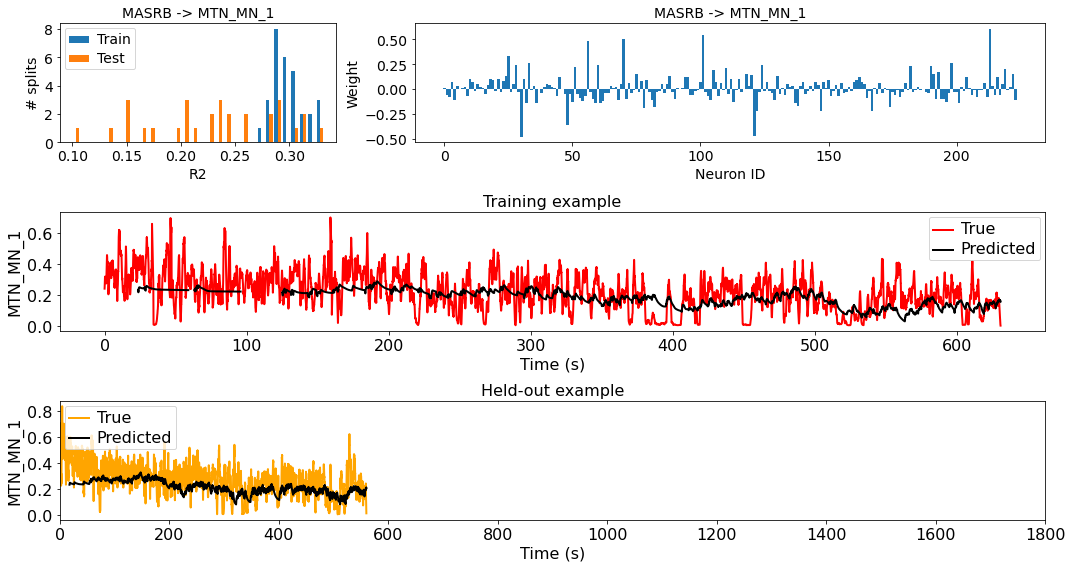

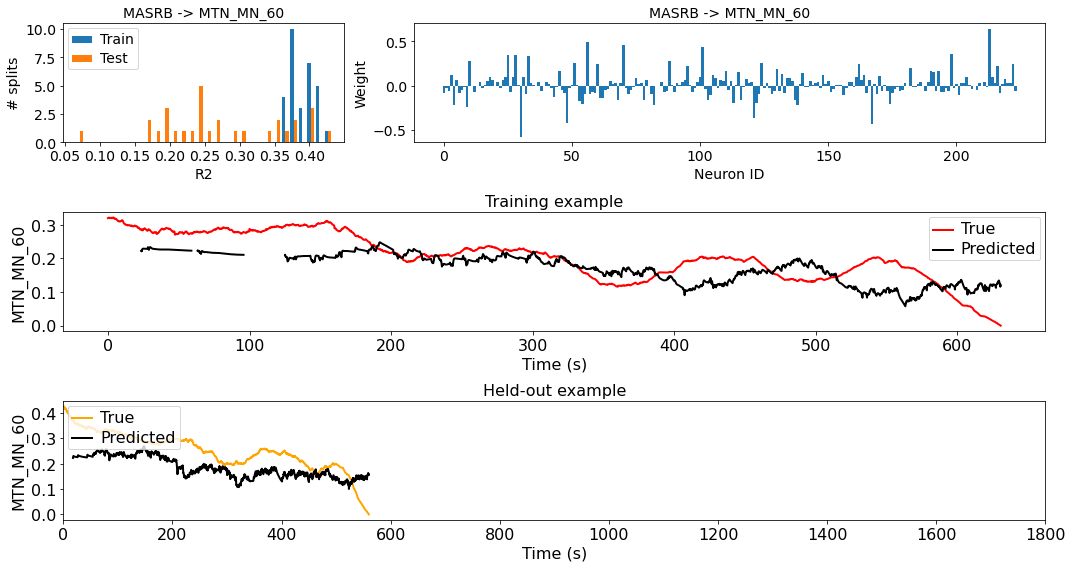

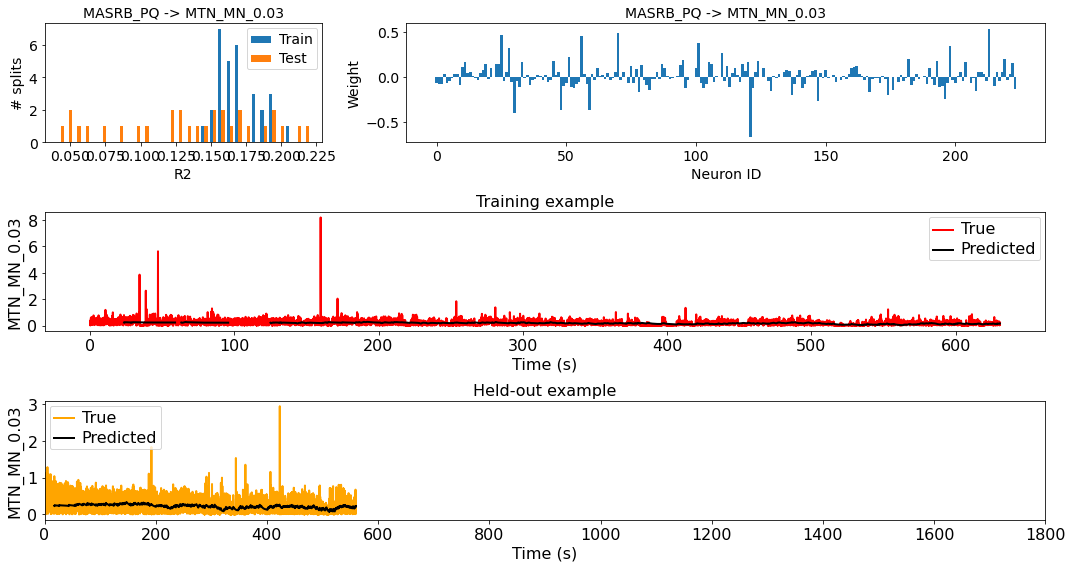

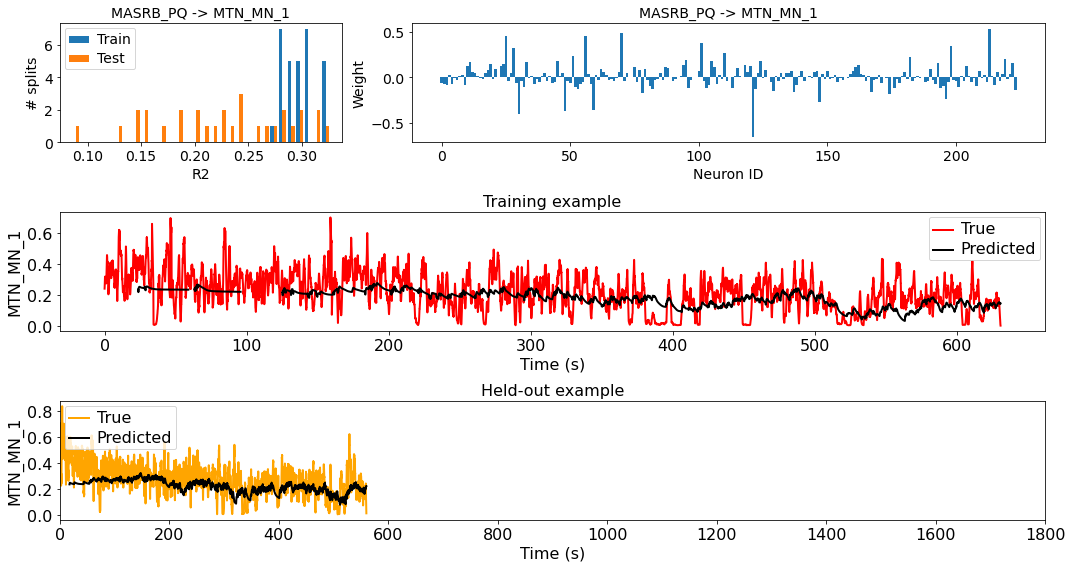

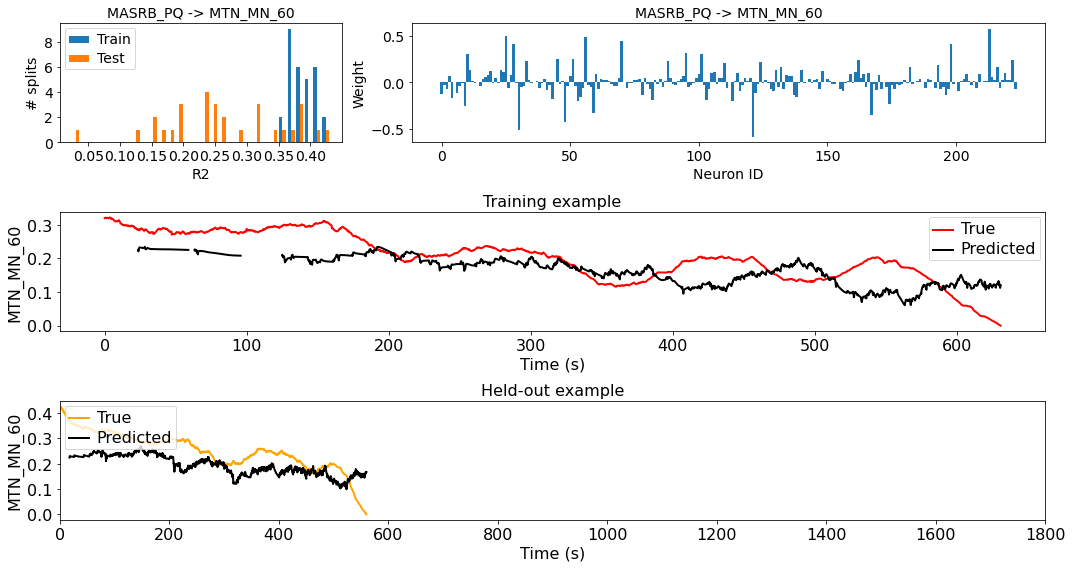

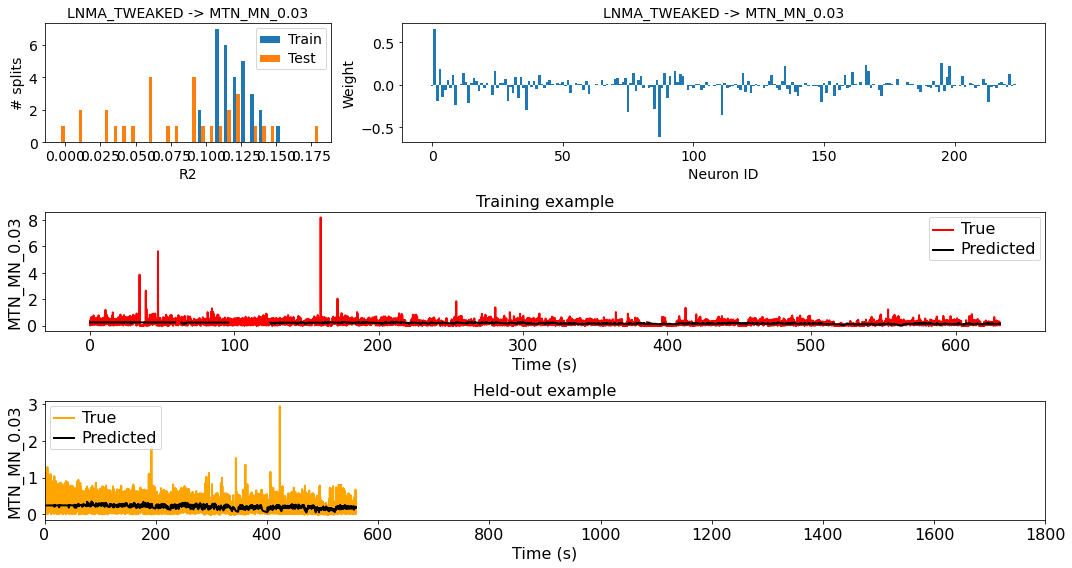

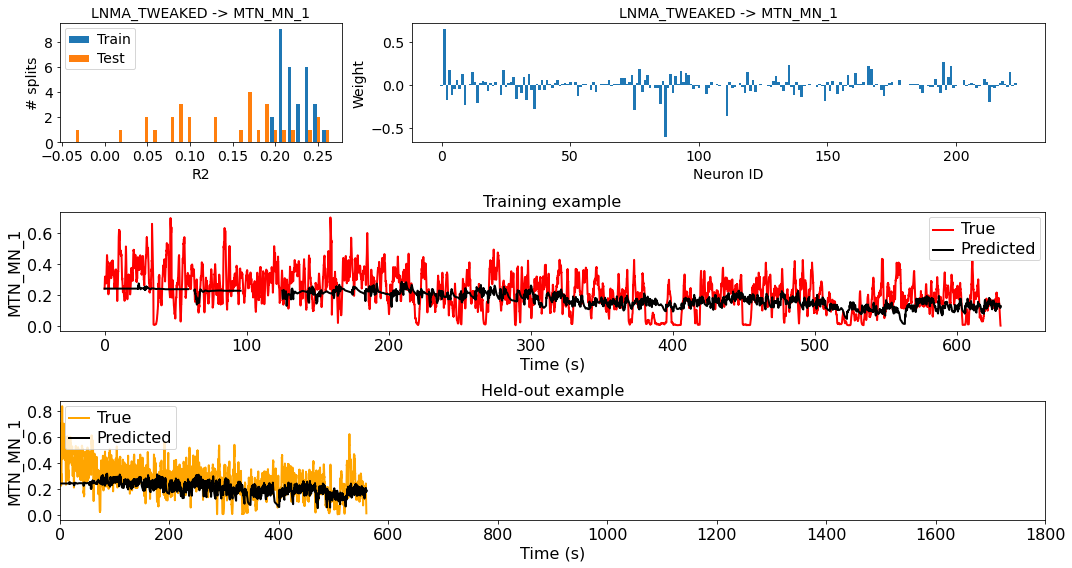

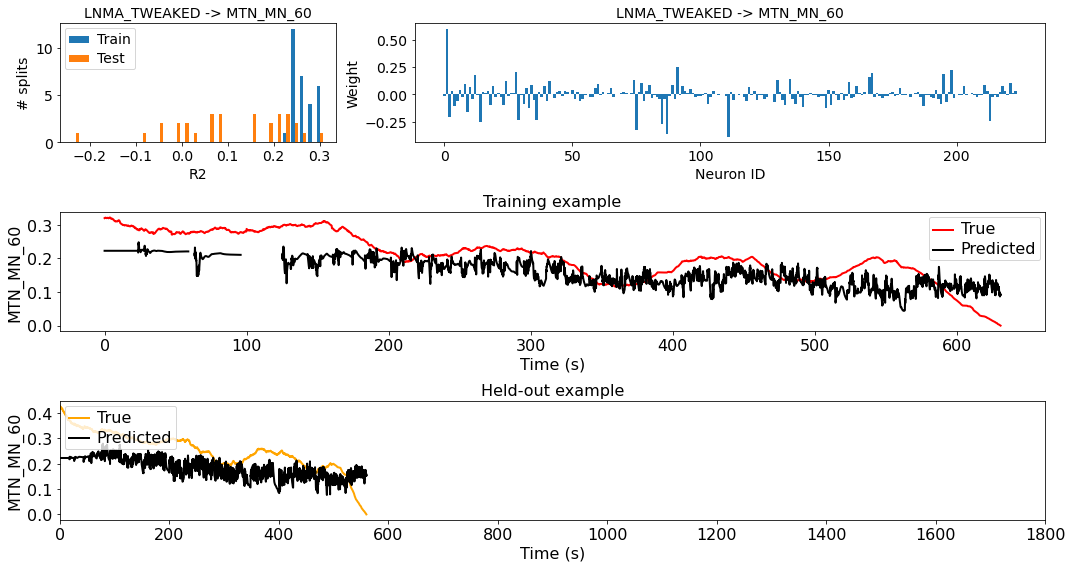

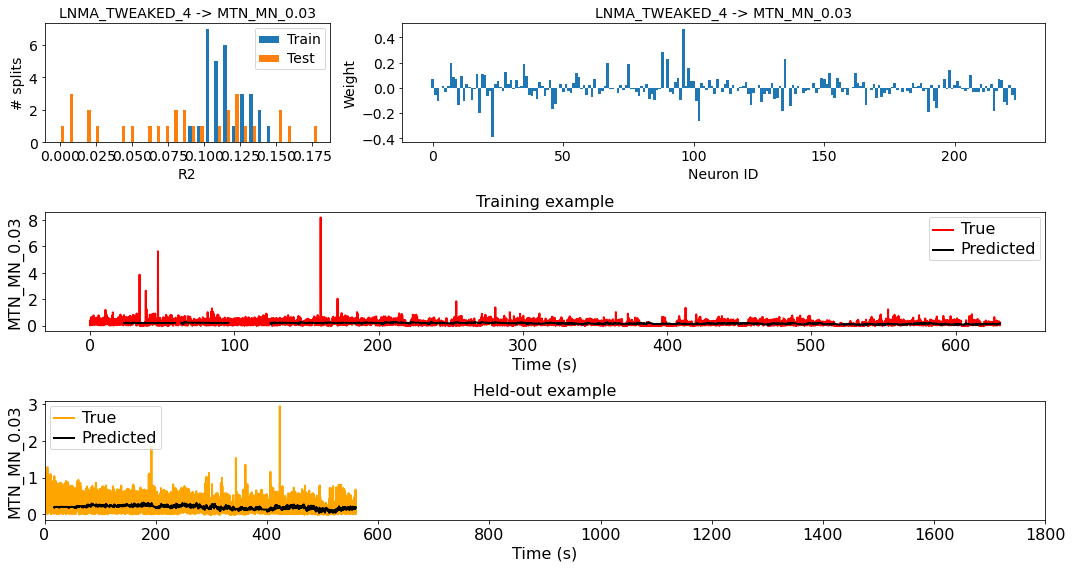

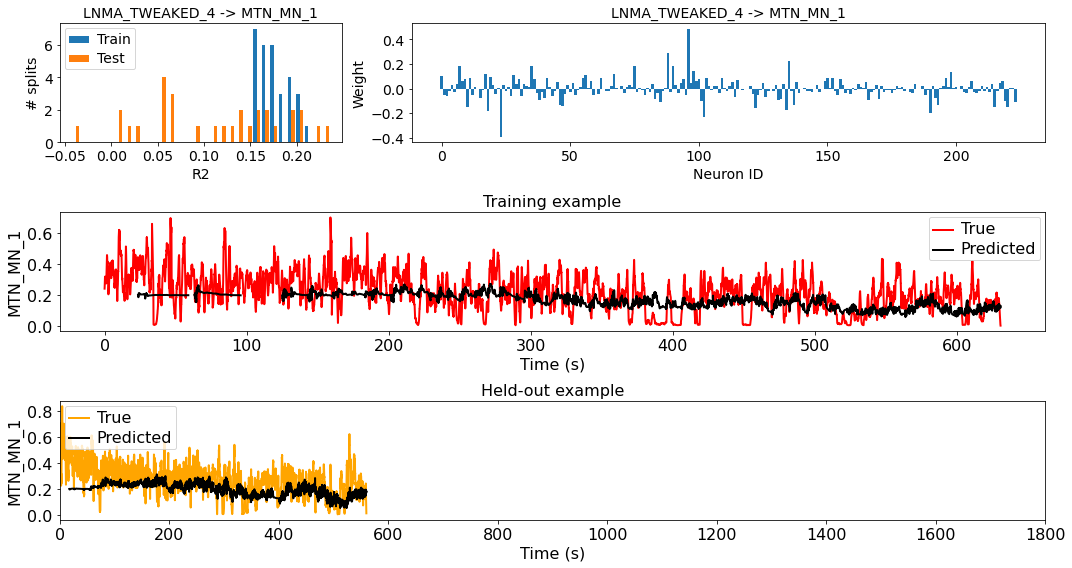

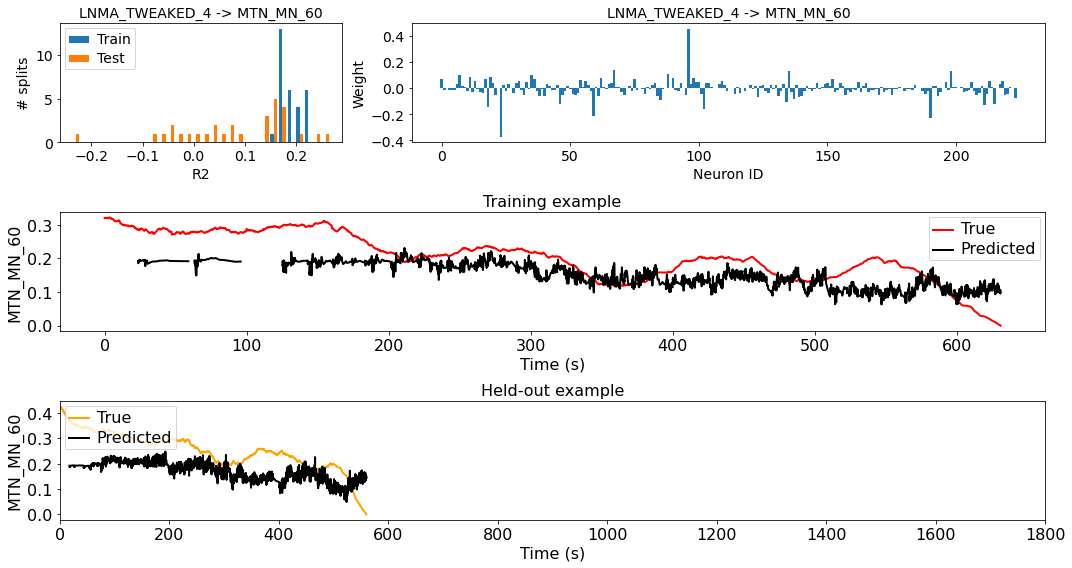

In [3]:
ISPLIT = 0
ITRAIN_PLOT = 1
ITEST_PLOT = 1

FPS = 30.03

for nrl_mdl in NRL_MDLS:
    print(nrl_mdl)
    fsave = f'data/simple/mlv/neur_basic/baker_{nrl_mdl}_{STRAIN_KEY}_{TARG_BHV.lower()}_ridge_alpha_{ALPHA}_masked.npy'
    data = np.load(fsave, allow_pickle=True)[0]

    for targ in TARGS:
        
        r2_train = data['r2_train'][targ]
        r2_test = data['r2_test'][targ]
        
        gs = gridspec.GridSpec(3, 3)

        fig = plt.figure(figsize=(15, 8), tight_layout=True)
        axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1:]), fig.add_subplot(gs[1, :]), fig.add_subplot(gs[2, :])]

        axs[0].hist(np.transpose([r2_train, r2_test]), bins=30)
        axs[0].legend(['Train', 'Test'])
        
        print(np.mean(r2_test))
        
        set_plot(axs[0], x_label='R2', y_label='# splits', title=f'{nrl_mdl.upper()} -> {targ}', font_size=14)

        axs[1].bar(np.arange(data['w'][targ].shape[1]), np.mean(data['w'][targ], axis=0), width=1)
        set_plot(axs[1], x_label='Neuron ID', y_label='Weight', title=f'{nrl_mdl.upper()} -> {targ}', font_size=14)

        y_train = data['ys_train'][targ][ISPLIT][ITRAIN_PLOT]
        t_train = np.arange(len(y_train))/FPS
        
        y_hat_train = data['y_hats_train'][targ][ISPLIT][ITRAIN_PLOT]
        
        axs[2].plot(t_train, y_train, c='r', lw=2)
        axs[2].plot(t_train, y_hat_train, c='k', lw=2)
        
        axs[2].legend(['True', 'Predicted'])
        
        set_plot(axs[2], x_label='Time (s)', y_label=targ, title='Training example', font_size=16)

        y_test = data['ys_test'][targ][ISPLIT][ITEST_PLOT]
        t_test = np.arange(len(y_test))/FPS
        
        y_hat_test = data['y_hats_test'][targ][ISPLIT][ITEST_PLOT]
        
        axs[3].plot(t_test, y_test, c='orange', lw=2)
        axs[3].plot(t_test, y_hat_test, c='k', lw=2)
        
        axs[3].legend(['True', 'Predicted'], loc='upper left')
        
        set_plot(axs[3], x_lim=(0, 1800), x_label='Time (s)', y_label=targ, title='Held-out example', font_size=16)
        
    print()